<a href="https://colab.research.google.com/github/Aditya-11/Reinforcement_Learning_based_Algorithmic_Trading-Al/blob/master/stock_trade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

import numpy as np
import random 
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 3
        self.memory = deque(maxlen = 1000000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.0001
        self.epsilon_decay = 0.9995

        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dropout(.2))
        model.add(BatchNormalization())
        model.add(Dense(units=32, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(units=8,  activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(self.action_size , activation = "linear"))
        model.compile(loss = "mse", optimizer = Adam(lr=0.0019))   
        return model 

    def act(self,state):
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        #print(state)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        """
        for i in range(l - batch_size + 1,1):
            mini_batch.append(self.memory[i])

        """

        mini_batch = random.sample(self.memory,batch_size)

        for state , action , reward , next_state , done in mini_batch:
            target = reward

            if not done:
                #print(next_state)
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            target_f = self.model.predict(state)
            target_f[0][action] = target

            self.model.fit(state, target_f , epochs = 1, verbose = 0)

        if self.epsilon > self.epsilon_min :
            self.epsilon *= self.epsilon * self.epsilon_decay


In [ ]:
!pip install tensorflow==2
!pip install -U tf-nightly-gpu

     |████████████████████████████████| 86.3MB 75kB/s 
     |████████████████████████████████| 450kB 27.9MB/s 
     |████████████████████████████████| 3.8MB 37.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=0593c1d1bae67decada0e3a2a0be4e2f854946864026457eceade98e5649aa77
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation

     |████████████████████████████████| 520.1MB 32kB/s 
     |████████████████████████████████| 460kB 37.6MB/s 
     |████████████████████████████████| 2.9MB 34.1MB/s 
ERROR: tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2


In [ ]:
import numpy as np
import math 
import pandas as pd

def formatPrice(n):
    # return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))
    return ("-$" if n<0 else "$") + "{0:2f}".format(abs(n))

def getStockDataVec(key):
    vec = []
    key = key + '.csv'
    col = 'close'
    ibm = pd.read_csv(key , usecols = [col])
    
    for index , row in ibm.iterrows():
        if (index > 1100):
            break
        vec.append(row['close'])
    
    print("block len",len(vec))
    
    return vec

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def getState(data ,t,n):
    d = t -n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        #print(sigmoid(block[i+1]))
        #print(block[i+1])
        #print(sigmoid(block[i + 1] - block[i]))
        res.append(sigmoid(block[i + 1] - block[i]))

    return np.array([res])

def getStockDataVec_test(key):
    vec = []
    key = key + '.csv'
    col = 'close'
    ibm = pd.read_csv(key , usecols= [col])

    for index , row in ibm.iterrows():
        if (index > 3200):
            vec.append(row['close'])
        elif (index > 3400):
            break
        else :
            continue
    return vec


In [ ]:
stock_name = 'daily_IBM'
window_size = 60
episode_count = 6
profit_values = []

agent = Agent(window_size)
data = getStockDataVec(stock_name)
l = len(data)-1

batch_size = 32
profit_values = []

with tf.device('/gpu:0'):
    for e in range(episode_count+1):
        print('Episode : ' + str(e))
        state = getState(data,0,window_size+1)
        agent.inventory = []
        action_taken = []
        total_profit = 0

        for t in range(l):
            action = agent.act(state)
            action_taken.append(action)
            next_state = getState(data, t + 1, window_size + 1)
            reward = 0

            if action == 1:
                agent.inventory.append(data[t])
            
            elif action == 2 and len(agent.inventory) > 0 : 
                bought_price = agent.inventory.pop(0)
                reward = max(data[t] - bought_price,0)
                total_profit += data[t] - bought_price
                print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
            
            done = True if t == l - 1 else False
            agent.memory.append((state, action, reward, next_state, done))
            state = next_state

            if done :
                print("----------------------------")
                print("Total Profit: " + formatPrice(total_profit))
                #profit_taken.append(total_profit)
                profit_values.append(total_profit)
                print(action_taken)
                print("-----------------------------")
            
            if (len(agent.memory)>batch_size):
                agent.expReplay(batch_size)
# 241.851500 93.600000 74.500000 -730.030000 -57.840000 382.560000 1049.410000

block len 1101
Episode : 0
Sell: $151.500000 | Profit: -$1.538500
Sell: $153.230000 | Profit: $0.400000
Sell: $152.500000 | Profit: -$0.830000
Sell: $156.460000 | Profit: $2.890000
Sell: $151.950000 | Profit: $0.110000
Sell: $148.970000 | Profit: -$1.540000
Sell: $149.160000 | Profit: $0.760000
Sell: $151.570000 | Profit: $1.270000
Sell: $153.350000 | Profit: $2.510000
Sell: $153.680000 | Profit: $2.100000
Sell: $153.600000 | Profit: -$0.430000
Sell: $159.550000 | Profit: $5.190000
Sell: $159.530000 | Profit: -$1.370000
Sell: $147.620000 | Profit: $0.520000
Sell: $144.820000 | Profit: -$1.060000
Sell: $145.540000 | Profit: $0.990000
Sell: $144.080000 | Profit: $1.040000
Sell: $145.160000 | Profit: $1.690000
Sell: $144.290000 | Profit: -$0.650000
Sell: $145.360000 | Profit: $0.060000
Sell: $145.990000 | Profit: $0.920000
Sell: $147.080000 | Profit: $0.890000
Sell: $147.530000 | Profit: -$0.130000
Sell: $153.010000 | Profit: -$0.990000
Sell: $155.580000 | Profit: $2.390000
Sell: $154.130

In [ ]:
# stock normal 112 done

print(action_taken)
print(profit_values)

agent.model.save('dqtrader_normal_112.h5')
from google.colab import files
files.download('dqtrader_normal_112.h5')

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 

In [ ]:
import pandas as pd
col = 'close'
ibm = pd.read_csv('daily_IBM.csv', usecols=[col])

print(type(ibm))

vec = []

for index, row in ibm.iterrows():
  if (index>2000):
    break
  vec.append(row['close'])

print(len(vec))

<class 'pandas.core.frame.DataFrame'>
2001


In [ ]:
import tensorflow as tf
import keras
print(keras.__version__)
print(tf.__version__)
print(tf.__git_version__)

2.3.1
2.0.0
v2.0.0-rc2-26-g64c3d38


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2863785486011971403
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2203688654746054889
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 605479924315316402
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7304675328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10838744382033972751
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [ ]:
# testing 
import tensorflow 
from tensorflow.keras.models import load_model 

stock_name = 'daily_IBM' 
model_name = 'dqtrader_normal_112.h5'
#model = load_model(model_name)
window_size = 60 

agent = Agent(window_size , True , model_name)
data = getStockDataVec_test(stock_name)

l = len(data) - 1

print(l)

batch_size = 32

state = getState(data , 0 , window_size + 1)
total_profit = 0

action_taken = []

for t in range(l):
    action = agent.act(state)

    #next_state = getState(data , 0, window_size + 1)
    
    next_state = getState(data, t + 1, window_size + 1)

    reward = 0 

    if action == 1:
        agent.inventory.append(data[t])
        print("Buy : ", formatPrice(data[t]))
    
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
    
    done = True if t == l -1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    action_taken.append(action)

    if done:
        print(stock_name + " Total Profit: " + formatPrice(total_profit))



1324
Buy :  $85.750000
Buy :  $86.200000
Buy :  $87.600000
Buy :  $88.440000
Buy :  $89.000000
Buy :  $89.570000
Buy :  $90.320000
Buy :  $90.440000
Buy :  $91.380000
Buy :  $90.680000
Buy :  $90.600000
Buy :  $91.040000
Buy :  $90.700000
Buy :  $90.520000
Buy :  $89.500000
Sell: $89.510000 | Profit: $3.760000
Buy :  $89.280000
Buy :  $89.860000
Sell: $90.650000 | Profit: $4.450000
Buy :  $91.380000
Buy :  $91.900000
Buy :  $91.510000
Sell: $92.410000 | Profit: $4.810000
Buy :  $92.350000
Buy :  $92.130000
Buy :  $91.600000
Buy :  $92.370000
Buy :  $92.410000
Sell: $92.920000 | Profit: $4.480000
Sell: $93.300000 | Profit: $4.300000
Buy :  $92.580000
Buy :  $92.800000
Buy :  $92.320000
Buy :  $93.270000
Buy :  $93.750000
Buy :  $94.620000
Buy :  $94.330000
Buy :  $93.570000
Buy :  $93.300000
Buy :  $92.760000
Buy :  $92.700000
Buy :  $94.130000
Buy :  $94.530000
Buy :  $94.510000
Sell: $93.540000 | Profit: $3.970000
Sell: $94.300000 | Profit: $3.980000
Buy :  $93.860000
Buy :  $91.95000

In [ ]:
import matplotlib.pyplot

print(len(action_taken))

print(len(data))

1324
1325


[   nan    nan    nan 117.4     nan    nan    nan 122.14    nan    nan
 124.05    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan 121.34    nan 120.25    nan 121.5     nan    nan
    nan    nan    nan    nan    nan    nan    nan 114.2     nan    nan
 114.34 115.44    nan    nan 114.75    nan    nan    nan    nan    nan
    nan    nan 109.97    nan 109.89    nan    nan    nan    nan    nan]


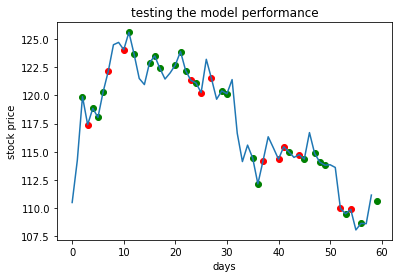

In [ ]:
i = 0
j = 0

import matplotlib.pyplot as plt
plt.plot(range(len(data[811:870])),data[811:870])

def selling(x):
    global i
    if (x==2):
        i+=1
        return data[i+810];
    i+=1
    return None;

def buying(x):
    global j
    if (x == 1):
        j+=1
        return data[j+810];
    j+=1
    return None;

sell1 = map(selling, action_taken[810:870]) 
buy11 = map(buying ,action_taken[810:870])

sell1 = np.fromiter(sell1, dtype=np.float)
buy11 = np.fromiter(buy11, dtype=np.float)

print(sell1)

plt.scatter(range(len(data[810:870])),sell1,color='red')
plt.scatter(range(len(data[810:870])),buy11,color='green')
plt.title('testing the model performance')
plt.xlabel('days')
plt.ylabel('stock price')
plt.show()


In [ ]:
print(action_taken)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 2, 0, 1, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 0, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 

Text(0, 0.5, 'Total profit')

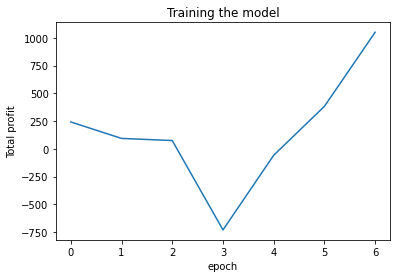

In [ ]:
import matplotlib.pyplot as plt
x = [241.851500,93.600000,74.500000,-730.030000,-57.840000,382.560000,1049.410000]
plt.plot(range(len(x)),x)
plt.title("Training the model")
plt.xlabel("epoch")
plt.ylabel("Total profit")